**Note:** Images are derived from a public image set, that can be used for non-commercial purposes.

# Prompt 1: 
I have two images of the same object, with some offset in angle and position. Stitch them into one panorama. I want to see the entire process of analysis and finding the points of interest in the images, aligning them, and stitching them together. You can only use cv2 for very basic tasks (read, write, decode etc) and perspectiveTransform (due to its complexity). Make this interactive on the python notebook by allowing users to upload their images using ipywidgets and display the final panorama. I am interested in the Harris and SIFT features and how they can be used to align the images. Since I want to understand the process, please provide a detailed explanation of each step.

HTML(value='\n<style>\n    .widget-upload {\n        margin: 10px;\n    }\n    .widget-button {\n        backg…

/var/folders/f9/jdxhns6s5xqbjc5h71x7s2740000gn/T/ipykernel_20550/3034953215.py:511: RuntimeWarning: divide by zero encountered in divide
  pred_coords = pred_coords / pred_coords[2]
/var/folders/f9/jdxhns6s5xqbjc5h71x7s2740000gn/T/ipykernel_20550/3034953215.py:511: RuntimeWarning: invalid value encountered in divide
  pred_coords = pred_coords / pred_coords[2]


number of inliers: 73
best residual: 1.8824810042593603
homography: 
[[ 1.33087695e+00 -8.04487088e-02 -5.86298755e+02]
 [ 1.83394599e-01  1.25966234e+00 -1.83857129e+02]
 [ 2.96476812e-04  5.25725024e-05  1.00000000e+00]]


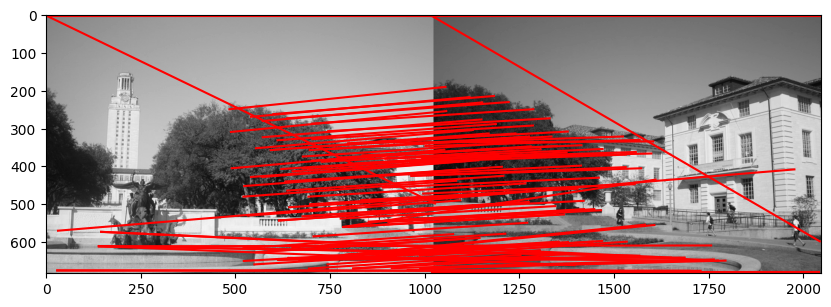

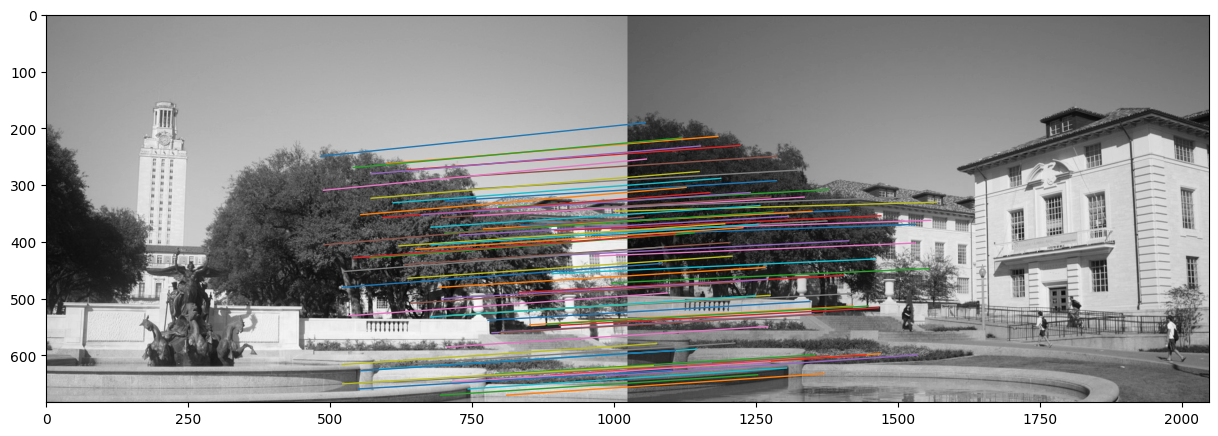

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# from skimage.transform import ProjectiveTransform
from sklearn.preprocessing import normalize
import numpy as np
from PIL import Image
import cv2 
from scipy.signal import convolve2d
from scipy.ndimage import rank_filter
from scipy.stats import norm
from ipywidgets import FileUpload, Button, HBox, VBox, Output, HTML, Layout

# ------------------------------------------------ Helper Functions ------------------------------------------------


def dist2(x, c):
    """
    Calculates squared distance between two sets of points.

    Parameters
    ----------
    x: numpy.ndarray
        Data of shape `(ndata, dimx)`
    c: numpy.ndarray
        Centers of shape `(ncenters, dimc)`

    Returns
    -------
    n2: numpy.ndarray
        Squared distances between each pair of data from x and c, of shape
        `(ndata, ncenters)`
    """
    assert x.shape[1] == c.shape[1], \
        'Data dimension does not match dimension of centers'

    x = np.expand_dims(x, axis=0)  # new shape will be `(1, ndata, dimx)`
    c = np.expand_dims(c, axis=1)  # new shape will be `(ncenters, 1, dimc)`

    # We will now use broadcasting to easily calculate pairwise distances
    n2 = np.sum((x - c) ** 2, axis=-1)

    return n2


def gen_dgauss(sigma):
    """
    Generates the horizontally and vertically differentiated Gaussian filter

    Parameters
    ----------
    sigma: float
        Standard deviation of the Gaussian distribution

    Returns
    -------
    Gx: numpy.ndarray
        First degree derivative of the Gaussian filter across rows
    Gy: numpy.ndarray
        First degree derivative of the Gaussian filter across columns
    """
    # Gaussian filter size
    f_wid = 4 * np.floor(sigma)
    # 1D Gaussian
    G = norm.pdf(np.arange(-f_wid, f_wid + 1), loc=0, scale=sigma).reshape(-1, 1)
    # 2D Gaussian
    G = G.T * G
    # Gradient of Gaussian
    Gx, Gy = np.gradient(G)
    # Normalize Gx and Gy
    Gx = Gx * 2 / np.abs(Gx).sum()
    Gy = Gy * 2 / np.abs(Gy).sum()

    return Gx, Gy

def rgb2gray(I):
    """
    Convert an RGB image to grayscale.

    Parameters:
    I (numpy.ndarray): Input image array in RGB format.

    Returns:
    numpy.ndarray: Grayscale image array.
    """
    # Convert numpy array to PIL Image
    image = Image.fromarray(I.astype('uint8'), 'RGB')
    # Convert the image to grayscale
    gray_image = image.convert('L')
    # Convert back to numpy array
    I_gray = np.array(gray_image)
    return I_gray


def find_sift(I, circles, enlarge_factor=1.5):
    """
    Compute non-rotation-invariant SIFT descriptors of a set of circles

    Parameters
    ----------
    I: numpy.ndarray
        Image
    circles: numpy.ndarray
        An array of shape `(ncircles, 3)` where ncircles is the number of
        circles, and each circle is defined by (x, y, r), where r is the radius
        of the cirlce
    enlarge_factor: float
        Factor which indicates by how much to enlarge the radius of the circle
        before computing the descriptor (a factor of 1.5 or large is usually
        necessary for best performance)

    Returns
    -------
    sift_arr: numpy.ndarray
        Array of SIFT descriptors of shape `(ncircles, 128)`
    """
    assert circles.ndim == 2 and circles.shape[1] == 3, \
        'Use circles array (keypoints array) of correct shape'

    I = I.astype(np.float64)
    if I.ndim == 3:
        I = rgb2gray(I)  # Convert to grayscale if image is RGB

    NUM_ANGLES = 8
    NUM_BINS = 4
    NUM_SAMPLES = NUM_BINS * NUM_BINS
    ALPHA = 9
    SIGMA_EDGE = 1

    ANGLE_STEP = 2 * np.pi / NUM_ANGLES
    angles = np.arange(0, 2 * np.pi, ANGLE_STEP)

    height, width = I.shape[:2]
    num_pts = circles.shape[0]

    sift_arr = np.zeros((num_pts, NUM_SAMPLES * NUM_ANGLES))

    Gx, Gy = gen_dgauss(SIGMA_EDGE)  # Generate Gaussian derivatives

    Ix = convolve2d(I, Gx, 'same')  # Convolve with Gx
    Iy = convolve2d(I, Gy, 'same')  # Convolve with Gy
    I_mag = np.sqrt(Ix ** 2 + Iy ** 2)  # Magnitude of gradient
    I_theta = np.arctan2(Ix, Iy + 1e-12)  # Orientation of gradient

    interval = np.arange(-1 + 1/NUM_BINS, 1 + 1/NUM_BINS, 2/NUM_BINS)
    gridx, gridy = np.meshgrid(interval, interval)
    gridx = gridx.reshape((1, -1))
    gridy = gridy.reshape((1, -1))

    I_orientation = np.zeros((height, width, NUM_ANGLES))

    for i in range(NUM_ANGLES):
        tmp = np.cos(I_theta - angles[i]) ** ALPHA
        tmp = tmp * (tmp > 0)  # Retain positive values only

        I_orientation[:, :, i] = tmp * I_mag  # Weighted magnitude

    for i in range(num_pts):
        cx, cy = circles[i, :2]
        r = circles[i, 2]

        gridx_t = gridx * r + cx
        gridy_t = gridy * r + cy
        grid_res = 2.0 / NUM_BINS * r

        x_lo = np.floor(np.max([cx - r - grid_res / 2, 0])).astype(np.int32)
        x_hi = np.ceil(np.min([cx + r + grid_res / 2, width])).astype(np.int32)
        y_lo = np.floor(np.max([cy - r - grid_res / 2, 0])).astype(np.int32)
        y_hi = np.ceil(np.min([cy + r + grid_res / 2, height])).astype(np.int32)

        grid_px, grid_py = np.meshgrid(
            np.arange(x_lo, x_hi, 1),
            np.arange(y_lo, y_hi, 1))
        grid_px = grid_px.reshape((-1, 1))
        grid_py = grid_py.reshape((-1, 1))

        dist_px = np.abs(grid_px - gridx_t)
        dist_py = np.abs(grid_py - gridy_t)

        weight_x = dist_px / (grid_res + 1e-12)
        weight_x = (1 - weight_x) * (weight_x <= 1)  # Weight based on distance
        weight_y = dist_py / (grid_res + 1e-12)
        weight_y = (1 - weight_y) * (weight_y <= 1)  # Weight based on distance
        weights = weight_x * weight_y  # Combined weights

        curr_sift = np.zeros((NUM_ANGLES, NUM_SAMPLES))
        for j in range(NUM_ANGLES):
            tmp = I_orientation[y_lo:y_hi, x_lo:x_hi, j].reshape((-1, 1))
            curr_sift[j, :] = (tmp * weights).sum(axis=0)  # Weighted sum
        sift_arr[i, :] = curr_sift.flatten()

    tmp = np.sqrt(np.sum(sift_arr ** 2, axis=-1))
    if np.sum(tmp > 1) > 0:
        sift_arr_norm = sift_arr[tmp > 1, :]
        sift_arr_norm /= tmp[tmp > 1].reshape(-1, 1)  # Normalize

        sift_arr_norm = np.clip(sift_arr_norm, sift_arr_norm.min(), 0.2)  # Clip values

        sift_arr_norm /= np.sqrt(
            np.sum(sift_arr_norm ** 2, axis=-1, keepdims=True))  # Renormalize

        sift_arr[tmp > 1, :] = sift_arr_norm

    return sift_arr


def harris(im, sigma, thresh=None, radius=None):
    """
    Harris corner detector

    Parameters
    ----------
    im: numpy.ndarray
        Image to be processed
    sigma: float
        Standard deviation of smoothing Gaussian
    thresh: float (optional)
    radius: float (optional)
        Radius of region considered in non-maximal suppression

    Returns
    -------
    cim: numpy.ndarray
        Binary image marking corners
    r: numpy.ndarray
        Row coordinates of corner points. Returned only if none of `thresh` and
        `radius` are None.
    c: numpy.ndarray
        Column coordinates of corner points. Returned only if none of `thresh`
        and `radius` are None.
    """
    if im.ndim == 3:
        im = rgb2gray(im)  # Convert to grayscale if image is RGB

    dx = np.tile([[-1, 0, 1]], [3, 1])
    dy = dx.T  # Transpose to get vertical Sobel filter

    Ix = convolve2d(im, dx, 'same')  # Convolve with horizontal Sobel filter
    Iy = convolve2d(im, dy, 'same')  # Convolve with vertical Sobel filter

    f_wid = np.round(3 * np.floor(sigma))  # Gaussian filter size
    G = norm.pdf(np.arange(-f_wid, f_wid + 1), loc=0, scale=sigma).reshape(-1, 1)
    G = G.T * G  # Create 2D Gaussian filter
    G /= G.sum()  # Normalize Gaussian filter

    Ix2 = convolve2d(Ix ** 2, G, 'same')  # Smooth Ix^2 with Gaussian
    Iy2 = convolve2d(Iy ** 2, G, 'same')  # Smooth Iy^2 with Gaussian
    Ixy = convolve2d(Ix * Iy, G, 'same')  # Smooth Ix*Iy with Gaussian

    cim = (Ix2 * Iy2 - Ixy ** 2) / (Ix2 + Iy2 + 1e-12)  # Harris corner response

    if thresh is None or radius is None:
        return cim
    else:
        size = int(2 * radius + 1)  # Size for rank filter
        mx = rank_filter(cim, -1, size=size)  # Apply rank filter to find local maxima
        cim = (cim == mx) & (cim > thresh)  # Threshold and find local maxima

        r, c = cim.nonzero()  # Get coordinates of corner points

        return cim, r, c
    
def draw_corners(img, r, c, img_name):
    """
    Draws rectangles around detected corner points on an image.

    Parameters
    ----------
    img: numpy.ndarray
        The image on which to draw the corners.
    r: numpy.ndarray
        Row coordinates of the corner points.
    c: numpy.ndarray
        Column coordinates of the corner points.
    img_name: str
        The name of the image.

    Returns
    -------
    None
        The function saves the image with rectangles drawn around the corner points.
    """
    # Create a copy of the image to draw on
    img_copy = img.copy()

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(10, 10))

    # Loop through each corner point
    for i in range(0, len(r)):
        # Create a rectangle patch at each corner point
        rect = patches.Rectangle((c[i], r[i]), 10, 10, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle patch to the axis
        ax.add_patch(rect)

    # Display/save the image with the corner points highlighted
    ax.imshow(img_copy, cmap='gray')
    plt.savefig(f'./data/out/{img_name}_corners.jpg')
    plt.close(fig)

def filter_descriptors_by_dist(distances, thresh):
    """
    Filters descriptor pairs based on a distance threshold.

    Parameters
    ----------
    distances : numpy.ndarray
        A 2D array where each element represents the distance between a pair of descriptors.
    thresh : float
        The distance threshold. Only descriptor pairs with distances below this threshold will be considered.

    Returns
    -------
    filtered_matches : numpy.ndarray
        A 2D array where each row contains the indices of the closest descriptor pairs that are below the threshold.
        The first column contains the indices of the closest descriptors, and the second column contains the indices
        of the original descriptors that are below the threshold.
    """
    # Find the indices of the pairs that are below the threshold
    indices_below_thresh = np.unique(np.where(distances < thresh)[0])
    distances_below_thresh = distances[indices_below_thresh]
    
    # Find the closest descriptors by sorting the distances and taking the first element
    closest_descs = np.argsort(distances_below_thresh, axis=1)[:, 0]

    # Reshape the arrays to be column vectors
    closest_descs = closest_descs.reshape(-1, 1)
    indices_below_thresh = indices_below_thresh.reshape(-1, 1)
    
    # Concatenate the closest descriptors and their corresponding indices
    filtered_matches = np.concatenate((closest_descs, indices_below_thresh), axis=1)
    
    return filtered_matches

def draw_matches(img1, img2, r1, c1, r2, c2, matches):
    """
    Draws lines matching the corners between two images using the filtered matches.

    Parameters
    ----------
    img1 : numpy.ndarray
        The first image.
    img2 : numpy.ndarray
        The second image.
    r1 : numpy.ndarray
        Row coordinates of the corner points in the first image.
    c1 : numpy.ndarray
        Column coordinates of the corner points in the first image.
    r2 : numpy.ndarray
        Row coordinates of the corner points in the second image.
    c2 : numpy.ndarray
        Column coordinates of the corner points in the second image.
    matches : numpy.ndarray
        A 2D array where each row contains the indices of matching corner points between the two images.

    Returns
    -------
    None
        The function displays/saves the two images side by side with lines connecting the matching corners.
    """
    img1_copy = img1.copy()
    # Create copies of the images to draw on
    img1_copy = img1.copy()
    img2_copy = img2.copy()

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(10, 10))

    # Display the two images side by side
    ax.imshow(np.hstack((img1_copy, img2_copy)), cmap='gray')

    # Loop through each match
    for i in range(0, matches.shape[0]):
        # Get coordinates of the matching point in the first image
        x1 = c1[matches[i, 0]]
        y1 = r1[matches[i, 0]]
        
        # Get coordinates of the matching point in the second image
        # Offset x2 by the width of the first image to align side by side
        x2 = c2[matches[i, 1]] + img1.shape[1]
        y2 = r2[matches[i, 1]]
        
        # Draw a red line connecting the matching points
        ax.plot([x1, x2], [y1, y2], 'r-')
        
    # Save the image
    fig.savefig('./data/out/matches.jpg')

def normalize_points(points):
    """
    Normalize a set of points so that the centroid is at the origin and the average distance to the origin is sqrt(2).
    
    Parameters:
    points (numpy.ndarray): Array of points of shape (N, 2).
    
    Returns:
    numpy.ndarray: Normalized points.
    numpy.ndarray: Normalization matrix.
    """
    centroid = np.mean(points, axis=0)

    # Center the points around the origin
    centered_points = points - centroid

    # Calculate the average distance of the points from the origin
    avg_dist = np.mean(np.sqrt(np.sum(centered_points**2, axis=1)))

    # Calculate the scaling factor
    scale = np.sqrt(2) / avg_dist

    # Create the normalization transformation matrix
    T = np.array([
        [scale, 0, -scale * centroid[0]],
        [0, scale, -scale * centroid[1]],
        [0, 0, 1]
    ])

    # Apply the normalization transformation to the points
    normalized_points = (T @ np.vstack((points.T, np.ones((1, points.shape[0]))))).T

    # Return the normalized points and the transformation matrix
    return normalized_points[:, :2], T

def compute_homography(points1, points2):
    """
    Compute the homography matrix from points1 to points2 using the DLT algorithm.
    
    Parameters:
    points1 (numpy.ndarray): Array of points in the first image of shape (N, 2).
    points2 (numpy.ndarray): Array of points in the second image of shape (N, 2).
    
    Returns:
    numpy.ndarray: Homography matrix of shape (3, 3).
    """
    # Normalize the points
    points1_normalized, T1 = normalize_points(points1)
    points2_normalized, T2 = normalize_points(points2)
    
    # Set up the linear system of equations
    N = points1.shape[0]
    A = []
    for i in range(N):
        x1, y1 = points1_normalized[i]
        x2, y2 = points2_normalized[i]
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])
    A = np.array(A)
    
    # Solve the system using SVD
    U, S, Vt = np.linalg.svd(A)
    H_normalized = Vt[-1].reshape(3, 3)
    
    # Denormalize the homography matrix
    H = np.linalg.inv(T2) @ H_normalized @ T1
    
    # Normalize so that H[2, 2] is 1
    H /= H[2, 2]
    
    return H

def RANSAC(filtered_matches, eps, num_loops, r1, c1, r2, c2):
    """
    Performs the RANSAC algorithm to find the best homography matrix.

    Parameters
    ----------
    filtered_matches : numpy.ndarray
        A 2D array where each row contains the indices of matching corner points between two images.
    eps : float
        The distance threshold to determine inliers.
    num_loops : int
        The number of iterations to run the RANSAC algorithm.
    r1 : numpy.ndarray
        Row coordinates of the corner points in the first image.
    c1 : numpy.ndarray
        Column coordinates of the corner points in the first image.
    r2 : numpy.ndarray
        Row coordinates of the corner points in the second image.
    c2 : numpy.ndarray
        Column coordinates of the corner points in the second image.

    Returns
    -------
    best_H : numpy.ndarray
        The best homography matrix found.
    max_inliers : int
        The maximum number of inliers found.
    best_residual : float
        The mean residual of the inliers.
    inlier_matches : numpy.ndarray
        The inlier matches corresponding to the best homography matrix.
    """
    max_inliers = 0
    best_residual = float('inf')
    best_H = None
    inlier_matches = None

    for i in range(0, num_loops):
        # randomly select 4 points
        indices = np.random.choice(filtered_matches.shape[0], 4, replace=False)
        selected_matches = filtered_matches[indices]

        # prepare points for cv2.findHomography
        points1 = np.float32([c1[selected_matches[:, 0]], r1[selected_matches[:, 0]]]).T
        points2 = np.float32([c2[selected_matches[:, 1]], r2[selected_matches[:, 1]]]).T

        # compute homography
        H = compute_homography(points1, points2)

        # compute predicted coordinates
        pred_coords = np.dot(H, np.vstack((c1[filtered_matches[:, 0]], r1[filtered_matches[:, 0]], np.ones(filtered_matches.shape[0]))))
        pred_coords = pred_coords / pred_coords[2]

        # calculate distance
        dist = np.sqrt(np.sum((np.vstack((c2[filtered_matches[:, 1]], r2[filtered_matches[:, 1]])) - pred_coords[:2]) ** 2, axis=0))

        # find indices where distance is less than threshold
        inliers = np.where(dist < eps)[0]

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_residual = np.mean(dist[inliers])
            best_H = H
            inlier_matches = filtered_matches[inliers]

    return best_H, max_inliers, best_residual, inlier_matches

def draw_inliers(img1, img2, r1, c1, r2, c2, inlier_matches):
    """
    Draws lines connecting inlier matches between two images.

    Parameters
    ----------
    img1 : numpy.ndarray
        The first image.
    img2 : numpy.ndarray
        The second image.
    r1 : numpy.ndarray
        Row coordinates of the corner points in the first image.
    c1 : numpy.ndarray
        Column coordinates of the corner points in the first image.
    r2 : numpy.ndarray
        Row coordinates of the corner points in the second image.
    c2 : numpy.ndarray
        Column coordinates of the corner points in the second image.
    inlier_matches : numpy.ndarray
        A 2D array where each row contains the indices of inlier matches between the two images.

    Returns
    -------
    None
        The function displays/saves the two images side by side with lines connecting the inlier matches.
    """
    # Create copies of the images to draw on
    img1_copy = img1.copy()
    img2_copy = img2.copy()

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(15, 10))

    # Concatenate the images side by side
    combined_img = np.hstack((img1_copy, img2_copy))

    # Display the combined image
    ax.imshow(combined_img, cmap='gray')

    # Loop through each inlier match
    for i in range(inlier_matches.shape[0]):
        # Get coordinates of the matching point in the first image
        x1 = c1[inlier_matches[i, 0]]
        y1 = r1[inlier_matches[i, 0]]

        # Get coordinates of the matching point in the second image
        # Offset x2 by the width of the first image to align side by side
        x2 = c2[inlier_matches[i, 1]] + img1.shape[1]
        y2 = r2[inlier_matches[i, 1]]

        # Draw a line connecting the matching points
        ax.plot([x1, x2], [y1, y2], '-', linewidth=1)

    # Save the image
    fig.savefig('./data/out/inliers.jpg')

def warp_perspective_manual(image, H, output_shape):
    """
    Apply a perspective warp to an image using a homography matrix.

    Parameters:
    image (numpy.ndarray): Input image.
    H (numpy.ndarray): Homography matrix.
    output_shape (tuple): Shape of the output image (height, width).

    Returns:
    numpy.ndarray: Warped image.
    """
    # Inverse homography matrix
    H_inv = np.linalg.inv(H)
    
    # Check if the image is grayscale or color
    if image.ndim == 2:
        # Grayscale image
        warped_image = np.zeros((output_shape[0], output_shape[1]), dtype=image.dtype)
    else:
        # Color image
        warped_image = np.zeros((output_shape[0], output_shape[1], image.shape[2]), dtype=image.dtype)
    
    # Iterate over each pixel in the destination image
    for y in range(output_shape[0]):
        for x in range(output_shape[1]):
            # Apply the inverse homography transformation
            dest_point = np.array([x, y, 1])
            src_point = H_inv @ dest_point
            src_point /= src_point[2]
            
            src_x, src_y = src_point[0], src_point[1]
            
            # Check if the source point is within the bounds of the source image
            if 0 <= src_x < image.shape[1] and 0 <= src_y < image.shape[0]:
                # Bilinear interpolation
                x0, y0 = int(np.floor(src_x)), int(np.floor(src_y))
                x1, y1 = min(x0 + 1, image.shape[1] - 1), min(y0 + 1, image.shape[0] - 1)
                
                a = src_x - x0
                b = src_y - y0
                
                if image.ndim == 2:
                    # Grayscale image
                    pixel_value = (
                        (1 - a) * (1 - b) * image[y0, x0] +
                        a * (1 - b) * image[y0, x1] +
                        (1 - a) * b * image[y1, x0] +
                        a * b * image[y1, x1]
                    )
                    warped_image[y, x] = pixel_value
                else:
                    # Color image
                    for c in range(image.shape[2]):
                        pixel_value = (
                            (1 - a) * (1 - b) * image[y0, x0, c] +
                            a * (1 - b) * image[y0, x1, c] +
                            (1 - a) * b * image[y1, x0, c] +
                            a * b * image[y1, x1, c]
                        )
                        warped_image[y, x, c] = pixel_value
    
    return warped_image

def warp_img(image_left, H):
    """
    Warps an image using a given homography matrix.

    Parameters
    ----------
    image_left : numpy.ndarray
        The input image to be warped.
    H : numpy.ndarray
        The homography matrix.

    Returns
    -------
    numpy.ndarray
        The warped image.
    """
    # Get the height and width of the input image
    h_left, w_left = image_left.shape[:2]

    # Define the corner points of the input image
    C_left = np.array([
        [0, 0     , w_left, w_left],
        [0, h_left, 0     , h_left],
        [1, 1     , 1     , 1     ]
    ])

    # Apply the homography matrix to the corner points
    Cp_left = H @ C_left
    Cp_left = Cp_left / Cp_left[-1, :]

    # Calculate the minimum x and y coordinates after transformation
    w_min, h_min = Cp_left[:-1].min(axis=1).tolist()
    w_min, h_min = int(np.abs(w_min)), int(np.abs(h_min))

    # Determine the shape of the warped image
    warped_image_shape = (w_left + w_min, h_left + h_min)
    # Create a translation matrix to shift the image
    Ht = np.array([
        [1, 0, w_min],
        [0, 1, h_min],
        [0, 0, 1    ]
    ])

    # Combine the translation matrix with the homography matrix
    Hw = Ht @ H
    Hw = Hw / Hw[-1, -1]

    # Warp the image using the combined homography matrix
    warped_image = warp_perspective_manual(image_left, Hw, warped_image_shape)

    return warped_image

def create_panorama(img1, img2, H):
    """
    Creates a panorama by stitching two images together using a homography matrix.

    Parameters
    ----------
    warped_img1 : numpy.ndarray
        The first image that has already been warped.
    img2 : numpy.ndarray
        The second image to be stitched with the first image.
    H : numpy.ndarray
        The homography matrix that transforms points from the second image to the first image's perspective.

    Returns
    -------
    numpy.ndarray
        The resulting panorama image.
    """
    # Get the dimensions of the images
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Get the canvas dimesions
    img1_dims = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    img2_dims_temp = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)

    # Get relative perspective of second image
    img2_dims = cv2.perspectiveTransform(img2_dims_temp, H)

    # Resulting dimensions
    result_dims = np.concatenate((img1_dims, img2_dims), axis = 0)

    # Getting images together
    # Calculate dimensions of match points
    [x_min, y_min] = np.int32(result_dims.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(result_dims.max(axis=0).ravel() + 0.5)
  
    # Create output array after affine transformation 
    transform_dist = [-x_min, -y_min]
    transform_array = np.array([[1, 0, transform_dist[0]], 
                                [0, 1, transform_dist[1]], 
                                [0,0,1]]) 

    # Warp images to get the resulting image
    result_img = warp_perspective_manual(img1, transform_array.dot(H), (y_max-y_min, x_max-x_min))

    # Blend the images where they overlap
    overlap_mask = (result_img[transform_dist[1]:h1+transform_dist[1], transform_dist[0]:w1+transform_dist[0]] > 0) & (img2 > 0)
    result_img[transform_dist[1]:h1+transform_dist[1], transform_dist[0]:w1+transform_dist[0]][overlap_mask] = (result_img[transform_dist[1]:h1+transform_dist[1], transform_dist[0]:w1+transform_dist[0]][overlap_mask] + img2[overlap_mask]) / 2
    result_img[transform_dist[1]:h1+transform_dist[1], transform_dist[0]:w1+transform_dist[0]][~overlap_mask] = img2[~overlap_mask]

    # This consolidates the overlap by placing the second image over the first (unused for now)

    return result_img

def create_panorama_rgb(img1, img2, H):
    """
    Creates a color panorama by stitching two images together using a homography matrix by applying it on each channel.

    Parameters
    ----------
    img1 : numpy.ndarray
        The first image to be stitched.
    img2 : numpy.ndarray
        The second image to be stitched.
    H : numpy.ndarray
        The homography matrix that transforms points from the second image to the first image's perspective.

    Returns
    -------
    numpy.ndarray
        The resulting panorama image.
    """
    # Get the dimensions of the images
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Get the canvas dimesions
    img1_dims = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    img2_dims_temp = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)

    # Get relative perspective of second image
    img2_dims = cv2.perspectiveTransform(img2_dims_temp, H)

    # Resulting dimensions
    result_dims = np.concatenate((img1_dims, img2_dims), axis = 0)

    # Getting images together
    # Calculate dimensions of match points
    [x_min, y_min] = np.int32(result_dims.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(result_dims.max(axis=0).ravel() + 0.5)
  
    # Create output array after affine transformation 
    transform_dist = [-x_min, -y_min]
    transform_array = np.array([[1, 0, transform_dist[0]], 
                                [0, 1, transform_dist[1]], 
                                [0,0,1]]) 

    # Warp images to get the resulting image
    # result_img = cv2.warpPerspective(img1, transform_array.dot(H), (x_max-x_min, y_max-y_min))
    result_img = warp_perspective_manual(img1, transform_array.dot(H), (y_max-y_min, x_max-x_min))
    
    # Blend the images where they overlap
    alpha = 0.5  # Set the weight for the images
    overlap_mask = (result_img[transform_dist[1]:h1+transform_dist[1], transform_dist[0]:w1+transform_dist[0]] > 0) & (img2 > 0)
    result_img[transform_dist[1]:h1+transform_dist[1], transform_dist[0]:w1+transform_dist[0]][overlap_mask] = alpha * result_img[transform_dist[1]:h1+transform_dist[1], transform_dist[0]:w1+transform_dist[0]][overlap_mask] + (1 - alpha) * img2[overlap_mask]

    result_img[transform_dist[1]:h1+transform_dist[1], transform_dist[0]:w1+transform_dist[0]][~overlap_mask] = img2[~overlap_mask]

    return result_img


# ------------------------------------------------ Main Procesing Function ------------------------------------------------

# Function to handle image display
def process_images(upload1, upload2):
    # Extract images from the uploads
    img1_data = upload1.value[0]['content']
    img2_data = upload2.value[0]['content']
    
    if img1_data is None or img2_data is None:
        raise ValueError("Please upload exactly two images.")
    
    # Decode the images using OpenCV
    img1_rgb = cv2.imdecode(np.frombuffer(img1_data, np.uint8), cv2.IMREAD_COLOR)
    img2_rgb = cv2.imdecode(np.frombuffer(img2_data, np.uint8), cv2.IMREAD_COLOR)

    # Convert images to RGB for display
    # img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    # img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Convert the RGB images to PIL Image objects
    img1_color = Image.fromarray(img1_rgb)
    img2_color = Image.fromarray(img2_rgb)

    # Convert images to grayscale
    img1_gray = img1_color.convert('L')
    img2_gray = img2_color.convert('L')

    # Convert grayscale images to numpy arrays
    img1 = np.array(img1_gray).astype(float)
    img2 = np.array(img2_gray).astype(float)

    # plt.imshow(img1, cmap='gray')
    cv2.imwrite('./data/out/img1_greyscale.jpg', img1)

    # Detect feature points in both images using the Harris corner detector
    sigma = 6
    thresh = 11
    radius = 3
    cim1, r1, c1 = harris(img1, sigma, thresh, radius)
    cim2, r2, c2 = harris(img2, sigma, thresh, radius)

    draw_corners(img1, r1, c1, 'img1')
    draw_corners(img2, r2, c2, 'img2')


    # Compute SIFT descriptors for the detected feature points

    radius_multiplier = 8

    radius_1 = np.ones(len(r1)) * radius_multiplier
    radius_2 = np.ones(len(r2)) * radius_multiplier

    circles_1 = np.ndarray((len(r1), 3))
    circles_2 = np.ndarray((len(r2), 3))

    for i in range(0, len(r1)):
        circles_1[i] = [c1[i], r1[i], radius_1[i]]

    for i in range(0, len(r2)):
        circles_2[i] = [c2[i], r2[i], radius_2[i]]

    enlarge_factor = 1.5

    # use find_sift from utils.py
    des1 = find_sift(img1, circles_1, enlarge_factor=enlarge_factor)
    des2 = find_sift(img2, circles_2, enlarge_factor=enlarge_factor)

    des1 = normalize(des1, norm='l2', axis=1)
    des2 = normalize(des2, norm='l2', axis=1)

    distances = dist2(des1, des2) # Compute distances between the descriptors

    # Select Matches based on a distance threshold
    thresh = 0.25
    filtered_matches = filter_descriptors_by_dist(distances, thresh)
    draw_matches(img1, img2, r1, c1, r2, c2, filtered_matches) # Draw matches

    # Use RANSAC to find the best homography matrix
    # report num of inliers and the average residual for the inliers
    H, max_inliers, best_residual, inlier_matches = RANSAC(filtered_matches, 5, 10000, r1, c1, r2, c2)
    print("number of inliers: " + str(max_inliers))
    print("best residual: " + str(best_residual))
    print("homography: ")
    print(H)

    draw_inliers(img1, img2, r1, c1, r2, c2, inlier_matches) # Draw inliers

    # Warp the images using the homography matrix
    warped_img1 = warp_img(img1, H)
    # Save the warped first image
    cv2.imwrite('./data/out/warped_img1.jpg', warped_img1)
    # Save the second image
    cv2.imwrite('./data/out/unwarped_img2.jpg', img2)

    # Create a panorama by stitching the images together

    # create a panorama in gray scale first
    panorama_gray = create_panorama(img1, img2, H)
    # Save the grayscale panorama
    cv2.imwrite('./data/out/panorama_gray.jpg', panorama_gray)

    # Create a color panorama using the homography matrix
    panorama = create_panorama_rgb(img1_rgb, img2_rgb, H)
    # Save the color panorama
    cv2.imwrite('./data/out/panorama_color.jpg', panorama)



# Widgets for file upload
upload1 = FileUpload(accept='image/*', multiple=False)
upload2 = FileUpload(accept='image/*', multiple=False)

# Display button
display_button = Button(description="Stitch Images")

# Output widget for displaying images
output = Output()

# Link button click to the display_images function
display_button.on_click(lambda _: process_images(upload1, upload2))

# Custom CSS for styling
custom_css = """
<style>
    .widget-upload {
        margin: 10px;
    }
    .widget-button {
        background-color: #4CAF50;
        color: white;
        border: none;
        padding-bottom: 10px;
        border-radius: 5px;
        font-size: 18px;
        margin: 10px;
        cursor: pointer;
    }
    .widget-output {
        background-color: #f9f9f9;
        border-radius: 5px;
        margin: 0px;
    }
    .widget-container {
        display: flex;
        align-items: center;
        width: 100%;
    }
    .widget-row {
        display: flex;
        justify-content: center;
        align-items: center;
        width: 100%;
    }
</style>
"""

# Display custom CSS
display(HTML(custom_css))

# Display widgets in the notebook
display(VBox([
    HBox([upload1, upload2], layout=Layout(justify_content='center', align_items='center')),
    display_button,
    output
], layout=Layout(align_items='center')))


In [3]:
from IPython.display import Markdown

Markdown('''

# Homography Image Stitching using Feature Detection and Matching

## Overview of the Homography Process

The image stitching process undertaken involved the following steps:

1. **Loading the Image as Greyscale**: The input images that were uploaded by the user underwent the following preprocessing steps:
    - Extraction of the content from the uploaded images (this method is specific to JPG files).
    - Decoding the images using ```OpenCV```.
    - Conversion to ```PIL``` Image objects, greyscale, and then to numpy ```float``` arrays.
2. **Feature Detection**: The Harris corner detector used local intensity gradients to identify corner points in the images. These corner points served as the features for matching.
3. **Feature Point Matching**: SIFT descriptors were computed for detected feature points.They were then normalized and pairwise distances between descriptors were calculated for accurate matching.
4. **Filtering Matches**:
    - Matches were filtered based on a distance threshold.
    - RANSAC was used to compute the best homography matrix.
    - The homography matric, number of inliers and the average residual for the inliers were reported.
5. **Image Warping**: One of the images was warped onto the other using the homography matrix.
6. **Image Blending**: The images were blended in Greyscale and then in RGB to create a seamless panorama.

## Code Format

A set of helper functions were defined to perform the various tasks associated with the image stitching process. The main processing function, ```process_images```, was responsible for orchestrating the entire process. The function took the uploaded images, performed the necessary steps, and generated the final panorama output.
The ```widgets``` module was used to create the file upload and button widgets for user interaction. The output was displayed using the ```Output``` widget.
         
## Step 1: Image loading and Preprocessing
         
Since the image was uploaded using the ```FileUpload``` widget, the image data was extracted from the uploads and decoded using ```OpenCV```. The images were then converted to greyscale and numpy arrays for further processing.
![Greyscale Image 1](./data/out/img1_greyscale.jpg)

## Step 2: Feature Detection

### Harris Corner Detection

The Harris corner detector was used to identify key points in the images. Image gradients are computed in the x and y directions using convolution. 
         These gradients are smoothed with a Gaussian filter, and the Harris response is calculated to identify corner points. 
         If the threshold and radius are provided, non-maximal suppression is applied to refine the corner points, returning their coordinates. <br>
        The detected corners are shown below:
![Detected Corners in Image 1](./data/out/img1_corners.jpg)
![Detected Corners in Image 2](./data/out/img2_corners.jpg)

### SIFT Descriptors

SIFT descriptors for detected feature points are computed by first defining a radius multiplier and creating circles around each feature point. 
         These circles are then used by the find_sift function from utils.py to compute the SIFT descriptors for both images, with an enlarge factor applied. 
         The resulting descriptors are normalized using L2 normalization. This ensures that the descriptors are scale-invariant and robust.

### Descriptor Filtering
The pairwise distances between the descriptors of the two images are calculated. The ones that fall below the specified threshold are considered as potential matches.
         ![Feature Matching Output](./data/out/matches.jpg)

> **Note**: There generally are some false matches that make it through this filtering process (due to various hyperparameters and the nature of the images). This will be addressed in the next step.

## Step 3: Homography Calculation
         
### `RANSAC` method

1. **RANSAC Iterations**:
    - For a specified number of iterations, the method randomly selects a subset of matches from the input data.
    - The selected matches are used to prepare the corresponding points for transformation computation.

2. **Transformation Computation and Prediction**:
    - The transformation matrix is computed using the selected points.
    - The predicted coordinates are calculated by applying the transformation matrix to the points from the first set.

3. **Inlier Detection**:
    - The Euclidean distance between the predicted coordinates and the actual coordinates from the second set is computed.
    - Points with a distance less than a specified threshold are considered inliers.
    - If the number of inliers is greater than the current maximum, the method updates the variables with the new values.

4. **Return Best Transformation**:
    - After all iterations, the method returns the best transformation matrix, the number of inliers, the best residual error, and the inlier matches.
         
         
### `compute_homography` method

1. **Normalization of Points**:
    - The method starts by normalizing the input sets of points from two images.
    - Normalization involves translating and scaling the points so that their centroid is at the origin and their average distance from the origin is √2.
    - This step ensures numerical stability during the computation.

2. **Setting Up the Linear System**:
    - The method initializes a list to store the coefficients of the linear system.
    - For each pair of corresponding points from the two images, two rows are added to the list.
    - These rows represent the constraints imposed by the homography transformation, resulting in a system of equations.

3. **Solving the System Using SVD**:
    - The list of coefficients is converted to a matrix, and Singular Value Decomposition (SVD) is performed on this matrix.
    - The homography matrix is obtained from the last row of the right singular vectors, reshaped into a 3x3 matrix.

4. **Denormalization and Normalization**:
    - The homography matrix is denormalized using the inverse of the normalization matrices obtained earlier.
    - The resulting matrix is then normalized so that its bottom-right element is 1, ensuring a consistent scale.
    - The final homography matrix is returned.

### Visualizing the Inliers
The inliers are visualized by drawing lines connecting the matching points in the two images.
![Inliers](./data/out/inliers.jpg)
         
## Step 4: Image Warping
         
### `warp_img` method
The warp_img function warps an input image using a homography matrix by first determining the new positions of the image corners after applying the homography. 
         It calculates the required size for the warped image to ensure that all transformed corners fit within the new image dimensions. 
         A translation homography is then applied to adjust the image coordinates, and the final warping is performed using a manual perspective warp function, returning the warped image.

### `warp_perspective_manual` method
- The function starts by computing the inverse of the homography matrix.
- It initializes an output image with the specified shape, ensuring it matches the type (grayscale or color) of the input image.
- For each pixel in the output image, the function applies the inverse homography transformation to find the corresponding source pixel in the input image.
- If the source pixel is within the bounds of the input image, the function uses bilinear interpolation to compute the pixel value for the output image, ensuring smooth transitions and accurate warping.

> **Note**: The warped image contains some black regions as information is lost during the angular and positional transformations. 

The warped image of the first input image is shown below:
![Warped Image 1](./data/out/warped_img1.jpg)
         
> **Note**: The second image remains unwarped for this part of the process.
         
## Step 5: Image Stitching (Panorama Creation)
         
### `create_panorama` Function

1. **Initialization**:
    - The function starts by obtaining the dimensions of the two input images.
    - It defines the corner points of each image to determine their boundaries.

2. **Perspective Transformation**:
    - The corner points of the second image are transformed using the provided homography matrix to get their relative perspective in the panorama.

3. **Canvas Dimensions Calculation**:
    - The function calculates the dimensions of the resulting panorama by combining the transformed corner points of both images.
    - It determines the minimum and maximum coordinates to create an output canvas that can accommodate both images.

4. **Affine Transformation and Warping**:
    - An affine transformation matrix is created to adjust the image coordinates, ensuring no negative coordinates.
    - The first image is warped onto the output canvas using a manual perspective warp function, applying the combined homography and affine transformation.

5. **Blending Overlapping Regions**:
    - The function identifies overlapping regions between the two images and blends them by averaging their pixel values.
    - It ensures that non-overlapping regions of the second image are directly copied to the output canvas.

6. **Return Result**:
    - The final panorama image, which seamlessly blends the two input images, is returned.

### `create_panorama_rgb` Function

1. **Color Image Handling**:
    - The function extends the `create_panorama` function to handle color images by processing each color channel separately.
    - It ensures that the blending and warping operations are applied consistently across all color channels.

2. **Channel-wise Blending**:
    - The function blends the overlapping regions for each color channel individually, ensuring smooth transitions and accurate color representation.
    - It combines the pixel values of the overlapping regions for each channel and ensures that non-overlapping regions of the second image are directly copied to the output canvas.

3. **Final Composition**:
    - The function composes the final panorama image by merging the processed color channels.
    - It returns the resulting color panorama image, which seamlessly blends the two input images.
         
## Final Panorama Output
         
The transition between the two images is seamless, but to highlight the blending of the individual images, their boundaries are preserved.

The final grey scale panorama is shown below:
![Grey Scale Panorama](./data/out/panorama_gray.jpg)
         
The final color panorama is shown below:
![Color Panorama](./data/out/panorama_color.jpg)
  
         
## Alternative Methods:

### Feature Matching

Other feature matching methods include:

- **FLANN (Fast Library for Approximate Nearest Neighbors)**:
    - Uses optimized data structures and algorithms for approximate nearest neighbor search, making it suitable for large datasets.
    - **Pros**: Highly efficient for large-scale problems, significantly faster than brute-force methods.
    - **Cons**: Slightly more complex to implement and may require parameter tuning for optimal performance.

- **K-Nearest Neighbors (KNN) with Lowe's Ratio Test**:
    - Finds the k-nearest neighbors for each feature point and applies Lowe's ratio test to filter out false matches by comparing the distance of the closest neighbor to the second closest neighbor.
    - **Pros**: Reduces false matches, improves matching accuracy.
    - **Cons**: Adds an additional computational step, can be slower for large datasets.

- **Brute-Force Matching**:
    - Compares each feature descriptor in one image with all feature descriptors in the other image using a distance metric (e.g., Euclidean distance).
    - **Pros**: Simple to implement, does not require parameter tuning.
    - **Cons**: Computationally expensive, not suitable for large datasets.

- **Binary Robust Independent Elementary Features (BRIEF)**:
    - Uses binary strings as feature descriptors, which are compared using Hamming distance.
    - **Pros**: Fast matching process, low computational cost.
    - **Cons**: Less robust to changes in scale and rotation compared to other methods.

- **Oriented FAST and Rotated BRIEF (ORB)**:
    - Combines the FAST keypoint detector and the BRIEF descriptor with added orientation information to improve robustness.
    - **Pros**: Efficient, performs well in real-time applications, free of patent restrictions.
    - **Cons**: May not be as accurate as SIFT or SURF, especially in complex scenes.

- **Scale-Invariant Feature Transform (SIFT)**:
    - Detects keypoints and computes descriptors that are invariant to scale, rotation, and illumination changes.
    - **Pros**: Highly distinctive descriptors, robust to various transformations, suitable for a wide range of applications.
    - **Cons**: Computationally intensive, slower than other methods, patented.

- **Speeded-Up Robust Features (SURF)**:
    - Similar to SIFT but uses integral images and a fast Hessian matrix-based detector to speed up the process.
    - **Pros**: Faster than SIFT, good balance between speed and accuracy.
    - **Cons**: Still more computationally demanding than ORB, patented.

- **AKAZE (Accelerated-KAZE)**:
    - Uses nonlinear scale spaces for feature detection and description, providing good performance in terms of speed and accuracy.
    - **Pros**: Suitable for real-time applications, efficient and accurate.
    - **Cons**: May not be as widely supported or tested as SIFT or SURF.

### Homography Calculation:

- **Direct Linear Transformation (DLT)**:
    - Uses a set of linear equations derived from point correspondences to compute the homography matrix.
    - **Pros**: Simple to implement, computationally efficient.
    - **Cons**: Less robust in the presence of outliers, sensitive to noise.

- **Levenberg-Marquardt Optimization**:
    - An iterative optimization algorithm that refines the homography matrix by minimizing the reprojection error.
    - **Pros**: Provides a more accurate and refined homography matrix, can handle non-linearities.
    - **Cons**: Requires an initial estimate, computationally intensive, may converge to local minima.

- **Random Sample Consensus (RANSAC)**:
    - Iteratively selects random subsets of correspondences to estimate the homography matrix and identifies inliers that fit the model.
    - **Pros**: Robust against outliers, does not require an initial estimate.
    - **Cons**: Computationally expensive due to multiple iterations, performance depends on the number of iterations and the quality of the data.

- **M-estimator Sample Consensus (MSAC)**:
    - A variant of RANSAC that uses M-estimators to improve the robustness of the homography estimation.
    - **Pros**: More robust to outliers compared to standard RANSAC, can provide better accuracy.
    - **Cons**: More complex to implement, computationally intensive.

- **Least Median of Squares (LMedS)**:
    - Minimizes the median of the squared residuals to estimate the homography matrix.
    - **Pros**: Robust to outliers, less sensitive to extreme values.
    - **Cons**: Computationally intensive, may not be as accurate as other methods for large datasets.

- **Iterative Closest Point (ICP)**:
    - Iteratively refines the homography matrix by minimizing the distance between corresponding points.
    - **Pros**: Can handle large datasets, provides accurate results.
    - **Cons**: Requires good initial alignment, may converge to local minima.
         
### Image Warping:

- **Affine Transformation**: 
    - Applies linear transformations including rotation, scaling, and translation, but does not handle perspective distortion.
    - **Pros**: Simple to implement, efficient for cases involving rotation, scaling, and translation.
    - **Cons**: Does not handle perspective distortion, limited to linear transformations.

- **Thin Plate Spline (TPS)**: 
    - Uses a flexible transformation model to handle complex warps and deformations.
    - **Pros**: Highly flexible, can handle complex warps and deformations.
    - **Cons**: Computationally expensive, more complex to implement.

## Summary Table of Methods and Outputs Descriptions

| Step                | Method Used          | Output Description                                            |
|---------------------|----------------------|----------------------------------------------------------------|
| Feature Detection   | Harris Corner Detector | Detected key points in both images.                             |
| Feature Matching    | SIFT Descriptors     | Computed and matched SIFT descriptors between the images.      |
| Match Filtering     | Distance Threshold | Filtered matches and computed the best homography matrix.       |
| Homography Calculation | RANSAC, DLT        | Computed the homography matrix to align the images.             |
| Image Warping       | WarpPerspective      | Warped one image to align with the other using homography.      |
| Image Blending      | Linear Blending      | Combined the images to create a seamless panorama.              |

## Conclusion
Various feature detection, matching, and homography estimation methods were implemented from scratch, resulting in a highly transparent and customizable image stitching process. 
The final panorama output demonstrates the effectiveness of the implemented algorithms in aligning and blending images seamlessly. 
Most of these methods are available in the OpenCV library, but implementing them from scratch provides a deeper understanding of the underlying concepts of image processing and widely used methods in computer vision.
''')




# Homography Image Stitching using Feature Detection and Matching

## Overview of the Homography Process

The image stitching process undertaken involved the following steps:

1. **Loading the Image as Greyscale**: The input images that were uploaded by the user underwent the following preprocessing steps:
    - Extraction of the content from the uploaded images (this method is specific to JPG files).
    - Decoding the images using ```OpenCV```.
    - Conversion to ```PIL``` Image objects, greyscale, and then to numpy ```float``` arrays.
2. **Feature Detection**: The Harris corner detector used local intensity gradients to identify corner points in the images. These corner points served as the features for matching.
3. **Feature Point Matching**: SIFT descriptors were computed for detected feature points.They were then normalized and pairwise distances between descriptors were calculated for accurate matching.
4. **Filtering Matches**:
    - Matches were filtered based on a distance threshold.
    - RANSAC was used to compute the best homography matrix.
    - The homography matric, number of inliers and the average residual for the inliers were reported.
5. **Image Warping**: One of the images was warped onto the other using the homography matrix.
6. **Image Blending**: The images were blended in Greyscale and then in RGB to create a seamless panorama.

## Code Format

A set of helper functions were defined to perform the various tasks associated with the image stitching process. The main processing function, ```process_images```, was responsible for orchestrating the entire process. The function took the uploaded images, performed the necessary steps, and generated the final panorama output.
The ```widgets``` module was used to create the file upload and button widgets for user interaction. The output was displayed using the ```Output``` widget.
         
## Step 1: Image loading and Preprocessing
         
Since the image was uploaded using the ```FileUpload``` widget, the image data was extracted from the uploads and decoded using ```OpenCV```. The images were then converted to greyscale and numpy arrays for further processing.
![Greyscale Image 1](./data/out/img1_greyscale.jpg)

## Step 2: Feature Detection

### Harris Corner Detection

The Harris corner detector was used to identify key points in the images. Image gradients are computed in the x and y directions using convolution. 
         These gradients are smoothed with a Gaussian filter, and the Harris response is calculated to identify corner points. 
         If the threshold and radius are provided, non-maximal suppression is applied to refine the corner points, returning their coordinates. <br>
        The detected corners are shown below:
![Detected Corners in Image 1](./data/out/img1_corners.jpg)
![Detected Corners in Image 2](./data/out/img2_corners.jpg)

### SIFT Descriptors

SIFT descriptors for detected feature points are computed by first defining a radius multiplier and creating circles around each feature point. 
         These circles are then used by the find_sift function from utils.py to compute the SIFT descriptors for both images, with an enlarge factor applied. 
         The resulting descriptors are normalized using L2 normalization. This ensures that the descriptors are scale-invariant and robust.

### Descriptor Filtering
The pairwise distances between the descriptors of the two images are calculated. The ones that fall below the specified threshold are considered as potential matches.
         ![Feature Matching Output](./data/out/matches.jpg)

> **Note**: There generally are some false matches that make it through this filtering process (due to various hyperparameters and the nature of the images). This will be addressed in the next step.

## Step 3: Homography Calculation
         
### `RANSAC` method

1. **RANSAC Iterations**:
    - For a specified number of iterations, the method randomly selects a subset of matches from the input data.
    - The selected matches are used to prepare the corresponding points for transformation computation.

2. **Transformation Computation and Prediction**:
    - The transformation matrix is computed using the selected points.
    - The predicted coordinates are calculated by applying the transformation matrix to the points from the first set.

3. **Inlier Detection**:
    - The Euclidean distance between the predicted coordinates and the actual coordinates from the second set is computed.
    - Points with a distance less than a specified threshold are considered inliers.
    - If the number of inliers is greater than the current maximum, the method updates the variables with the new values.

4. **Return Best Transformation**:
    - After all iterations, the method returns the best transformation matrix, the number of inliers, the best residual error, and the inlier matches.
         
         
### `compute_homography` method

1. **Normalization of Points**:
    - The method starts by normalizing the input sets of points from two images.
    - Normalization involves translating and scaling the points so that their centroid is at the origin and their average distance from the origin is √2.
    - This step ensures numerical stability during the computation.

2. **Setting Up the Linear System**:
    - The method initializes a list to store the coefficients of the linear system.
    - For each pair of corresponding points from the two images, two rows are added to the list.
    - These rows represent the constraints imposed by the homography transformation, resulting in a system of equations.

3. **Solving the System Using SVD**:
    - The list of coefficients is converted to a matrix, and Singular Value Decomposition (SVD) is performed on this matrix.
    - The homography matrix is obtained from the last row of the right singular vectors, reshaped into a 3x3 matrix.

4. **Denormalization and Normalization**:
    - The homography matrix is denormalized using the inverse of the normalization matrices obtained earlier.
    - The resulting matrix is then normalized so that its bottom-right element is 1, ensuring a consistent scale.
    - The final homography matrix is returned.

### Visualizing the Inliers
The inliers are visualized by drawing lines connecting the matching points in the two images.
![Inliers](./data/out/inliers.jpg)
         
## Step 4: Image Warping
         
### `warp_img` method
The warp_img function warps an input image using a homography matrix by first determining the new positions of the image corners after applying the homography. 
         It calculates the required size for the warped image to ensure that all transformed corners fit within the new image dimensions. 
         A translation homography is then applied to adjust the image coordinates, and the final warping is performed using a manual perspective warp function, returning the warped image.

### `warp_perspective_manual` method
- The function starts by computing the inverse of the homography matrix.
- It initializes an output image with the specified shape, ensuring it matches the type (grayscale or color) of the input image.
- For each pixel in the output image, the function applies the inverse homography transformation to find the corresponding source pixel in the input image.
- If the source pixel is within the bounds of the input image, the function uses bilinear interpolation to compute the pixel value for the output image, ensuring smooth transitions and accurate warping.

> **Note**: The warped image contains some black regions as information is lost during the angular and positional transformations. 

The warped image of the first input image is shown below:
![Warped Image 1](./data/out/warped_img1.jpg)
         
> **Note**: The second image remains unwarped for this part of the process.
         
## Step 5: Image Stitching (Panorama Creation)
         
### `create_panorama` Function

1. **Initialization**:
    - The function starts by obtaining the dimensions of the two input images.
    - It defines the corner points of each image to determine their boundaries.

2. **Perspective Transformation**:
    - The corner points of the second image are transformed using the provided homography matrix to get their relative perspective in the panorama.

3. **Canvas Dimensions Calculation**:
    - The function calculates the dimensions of the resulting panorama by combining the transformed corner points of both images.
    - It determines the minimum and maximum coordinates to create an output canvas that can accommodate both images.

4. **Affine Transformation and Warping**:
    - An affine transformation matrix is created to adjust the image coordinates, ensuring no negative coordinates.
    - The first image is warped onto the output canvas using a manual perspective warp function, applying the combined homography and affine transformation.

5. **Blending Overlapping Regions**:
    - The function identifies overlapping regions between the two images and blends them by averaging their pixel values.
    - It ensures that non-overlapping regions of the second image are directly copied to the output canvas.

6. **Return Result**:
    - The final panorama image, which seamlessly blends the two input images, is returned.

### `create_panorama_rgb` Function

1. **Color Image Handling**:
    - The function extends the `create_panorama` function to handle color images by processing each color channel separately.
    - It ensures that the blending and warping operations are applied consistently across all color channels.

2. **Channel-wise Blending**:
    - The function blends the overlapping regions for each color channel individually, ensuring smooth transitions and accurate color representation.
    - It combines the pixel values of the overlapping regions for each channel and ensures that non-overlapping regions of the second image are directly copied to the output canvas.

3. **Final Composition**:
    - The function composes the final panorama image by merging the processed color channels.
    - It returns the resulting color panorama image, which seamlessly blends the two input images.
         
## Final Panorama Output
         
The transition between the two images is seamless, but to highlight the blending of the individual images, their boundaries are preserved.

The final grey scale panorama is shown below:
![Grey Scale Panorama](./data/out/panorama_gray.jpg)
         
The final color panorama is shown below:
![Color Panorama](./data/out/panorama_color.jpg)
  
         
## Alternative Methods:

### Feature Matching

Other feature matching methods include:

- **FLANN (Fast Library for Approximate Nearest Neighbors)**:
    - Uses optimized data structures and algorithms for approximate nearest neighbor search, making it suitable for large datasets.
    - **Pros**: Highly efficient for large-scale problems, significantly faster than brute-force methods.
    - **Cons**: Slightly more complex to implement and may require parameter tuning for optimal performance.

- **K-Nearest Neighbors (KNN) with Lowe's Ratio Test**:
    - Finds the k-nearest neighbors for each feature point and applies Lowe's ratio test to filter out false matches by comparing the distance of the closest neighbor to the second closest neighbor.
    - **Pros**: Reduces false matches, improves matching accuracy.
    - **Cons**: Adds an additional computational step, can be slower for large datasets.

- **Brute-Force Matching**:
    - Compares each feature descriptor in one image with all feature descriptors in the other image using a distance metric (e.g., Euclidean distance).
    - **Pros**: Simple to implement, does not require parameter tuning.
    - **Cons**: Computationally expensive, not suitable for large datasets.

- **Binary Robust Independent Elementary Features (BRIEF)**:
    - Uses binary strings as feature descriptors, which are compared using Hamming distance.
    - **Pros**: Fast matching process, low computational cost.
    - **Cons**: Less robust to changes in scale and rotation compared to other methods.

- **Oriented FAST and Rotated BRIEF (ORB)**:
    - Combines the FAST keypoint detector and the BRIEF descriptor with added orientation information to improve robustness.
    - **Pros**: Efficient, performs well in real-time applications, free of patent restrictions.
    - **Cons**: May not be as accurate as SIFT or SURF, especially in complex scenes.

- **Scale-Invariant Feature Transform (SIFT)**:
    - Detects keypoints and computes descriptors that are invariant to scale, rotation, and illumination changes.
    - **Pros**: Highly distinctive descriptors, robust to various transformations, suitable for a wide range of applications.
    - **Cons**: Computationally intensive, slower than other methods, patented.

- **Speeded-Up Robust Features (SURF)**:
    - Similar to SIFT but uses integral images and a fast Hessian matrix-based detector to speed up the process.
    - **Pros**: Faster than SIFT, good balance between speed and accuracy.
    - **Cons**: Still more computationally demanding than ORB, patented.

- **AKAZE (Accelerated-KAZE)**:
    - Uses nonlinear scale spaces for feature detection and description, providing good performance in terms of speed and accuracy.
    - **Pros**: Suitable for real-time applications, efficient and accurate.
    - **Cons**: May not be as widely supported or tested as SIFT or SURF.

### Homography Calculation:

- **Direct Linear Transformation (DLT)**:
    - Uses a set of linear equations derived from point correspondences to compute the homography matrix.
    - **Pros**: Simple to implement, computationally efficient.
    - **Cons**: Less robust in the presence of outliers, sensitive to noise.

- **Levenberg-Marquardt Optimization**:
    - An iterative optimization algorithm that refines the homography matrix by minimizing the reprojection error.
    - **Pros**: Provides a more accurate and refined homography matrix, can handle non-linearities.
    - **Cons**: Requires an initial estimate, computationally intensive, may converge to local minima.

- **Random Sample Consensus (RANSAC)**:
    - Iteratively selects random subsets of correspondences to estimate the homography matrix and identifies inliers that fit the model.
    - **Pros**: Robust against outliers, does not require an initial estimate.
    - **Cons**: Computationally expensive due to multiple iterations, performance depends on the number of iterations and the quality of the data.

- **M-estimator Sample Consensus (MSAC)**:
    - A variant of RANSAC that uses M-estimators to improve the robustness of the homography estimation.
    - **Pros**: More robust to outliers compared to standard RANSAC, can provide better accuracy.
    - **Cons**: More complex to implement, computationally intensive.

- **Least Median of Squares (LMedS)**:
    - Minimizes the median of the squared residuals to estimate the homography matrix.
    - **Pros**: Robust to outliers, less sensitive to extreme values.
    - **Cons**: Computationally intensive, may not be as accurate as other methods for large datasets.

- **Iterative Closest Point (ICP)**:
    - Iteratively refines the homography matrix by minimizing the distance between corresponding points.
    - **Pros**: Can handle large datasets, provides accurate results.
    - **Cons**: Requires good initial alignment, may converge to local minima.
         
### Image Warping:

- **Affine Transformation**: 
    - Applies linear transformations including rotation, scaling, and translation, but does not handle perspective distortion.
    - **Pros**: Simple to implement, efficient for cases involving rotation, scaling, and translation.
    - **Cons**: Does not handle perspective distortion, limited to linear transformations.

- **Thin Plate Spline (TPS)**: 
    - Uses a flexible transformation model to handle complex warps and deformations.
    - **Pros**: Highly flexible, can handle complex warps and deformations.
    - **Cons**: Computationally expensive, more complex to implement.

## Summary Table of Methods and Outputs

## Summary Table of Methods and Outputs

| Step                | Method Used          | Output Description                                            |
|---------------------|----------------------|----------------------------------------------------------------|
| Feature Detection   | Harris Corner Detector | Detected key points in both images.                             |
| Feature Matching    | SIFT Descriptors     | Computed and matched SIFT descriptors between the images.      |
| Match Filtering     | Distance Threshold | Filtered matches and computed the best homography matrix.       |
| Homography Calculation | RANSAC, DLT        | Computed the homography matrix to align the images.             |
| Image Warping       | WarpPerspective      | Warped one image to align with the other using homography.      |
| Image Blending      | Linear Blending      | Combined the images to create a seamless panorama.              |

## Conclusion
Various feature detection, matching, and homography estimation methods were implemented from scratch, resulting in a highly transparent and customizable image stitching process. 
The final panorama output demonstrates the effectiveness of the implemented algorithms in aligning and blending images seamlessly. 
Most of these methods are available in the OpenCV library, but implementing them from scratch provides a deeper understanding of the underlying concepts of image processing and widely used methods in computer vision.
